# Setup

Install the necessary libraries in your Colab notebook environment and connect to your hosted Neo4J Sandbox.

In [ ]:
!pip install pyspark heatmapz seaborn

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from heatmap import heatmap, corrplot
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
save_folder = '/content/gdrive/My Drive/IASD_vacations/IASD_link_prediction/link-prediction/notebooks/data/'

Load the CSV files saved in the train/test notebook.

In [9]:
df_train_under = spark.read.csv(save_folder + 'df_train_under_all.csv/*.csv', header=True, inferSchema=True).cache()
df_test_under = spark.read.csv(save_folder + 'df_test_under_all.csv/*.csv', header=True, inferSchema=True).cache()

# Exploring the dataset

Let's dig into the dataset that we have built.




- Print the schema of the train dataset (as infered by Spark)

In [ ]:
df_train_under.printSchema()

Let's explore the features we have in our train dataset.

In [10]:
df_train_explore = df_train_under.select('label', 'cn', 'pa', 'tn', 'sl') # We only select the feature columns

- Run the following cell to check the dataframe for NaN or Null rows.



In [ ]:
for c in df_train_explore.columns:
  print("Number of mising values for column ", str(c))
  print(df_train_explore.filter(F.col(c).isNull() | F.isnan(F.col(c))).count())

- Print basic statistics for the positive and negative pairs in the train df. Can you already spot some differences between the positive and negative class? 

In [ ]:
df_train_explore.filter(F.col('label') == 0).describe().show()
df_train_explore.filter(F.col('label') == 1).describe().show()

To explore further, and challenge our intuitions, we are going plot correlations between variables.

Note : for this step, we transform the Spark DataFrame into a Pandas DataFrame in order to use this function.


In [ ]:
plt.figure(figsize=(8, 8))
corrplot(df_train_explore.toPandas().corr(), size_scale=300);

- Which feature(s) seem(s) to be the most correlated with our target variable?

In [ ]:
#@title Solution

"""
For a pair of nodes, by decreasing order of importance:
- the fact that they are in the same community (as detected by the Louvain alg.) and
- the number of common neighbors and
- the number of total neighbors
seem to be slightly correlated with our target variable (label)
"""

# Training the machine learning model

In this notebook we're going to create a machine learning model and train it against the features that we engineered in the previous notebook.

We’ll be using a **random forest classifier**. This method is well suited as our data set will be comprised of a mix of strong and weak features. Plus, it is an simple model that does not require a lot of features preprocessing.

We will be using a **Spark ML pipeline** to wrap all our data treatments, from preprocessing to prediction. A pipeline is composed of stages (transformers or estimators) that are run in order. 

Here is an illustration of a pipeline:

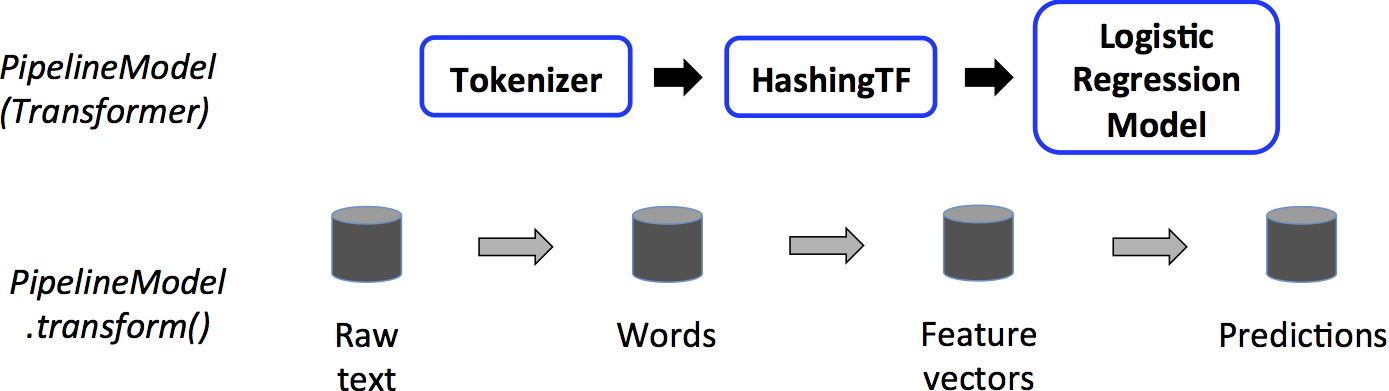



Let's initialize the stages that will compose our pipeline.

In [15]:
# We create an empty list that will contain our stages
stages = []

## Encodings

For each pair of nodes (each row), we need to produce a vector containing our encoded features and label to feed it to the Spark ML Lib model. 



In [13]:
# We only consider the features and label for the model, not the nodes IDs.

train_df = df_train_under.drop('node1', 'node2')
test_df = df_test_under.drop('node1', 'node2')
train_and_test = train_df.union(test_df)

### Label encoding

We need to create a mapping (an index) between each class label and a numeric value. For example, if we were doing a classification between three classes "a", "b", and "c" in the label column, we would need a mapping such as:

| categoryIndex | originalCategory
|---------------|-----------------
| 0.0           | a
| 2.0           | b
| 1.0           | c
| 0.0           | a
| 0.0           | a
| 1.0           | c

In our case, it is a bit overkill because our label column is already numeric (0 or 1), but let's do it anyway.

- Encode each category of the label column into a new column *indexedLabel*. Add this first treatment to our pipeline stages.

**Hint**: use a [StringIndexer](https://spark.apache.org/docs/latest/ml-features#stringindexer)


In [ ]:
# StringIndexer encodes a string column of labels to a column of label indices. 
# If the input column is numeric, it will be casted to string first.

labelIndexer = StringIndexer(inputCol = '...', outputCol = '...').fit(...) # This trained labelIndexer will be the first stage of our pipeline
stages += [...] # Add this stage to our pipeline stages list

In [16]:
#@title Solution

labelIndexer = StringIndexer(inputCol = 'label', outputCol = 'indexedLabel').fit(train_and_test) # We fit on the whole dataset to be sure to capture all possible labels
stages += [labelIndexer]

For the sake of illustration, let's check how our label column will be encoded when this first stage will be applied in our pipeline.

In [ ]:
# Each stage in the pipeline will be applied by calling its .transform() method

first_stage_result = stages[0].transform(train_df)
first_stage_result.show(5)
print(stages)

### Categorical feature encoding

Most of our features are numerical (*cn*, *pa*, *tn*) except one (*sl*) that is categorical -  as it expresses if the two nodes belong to the same community (True ou False). This binary variable needs to be encoded to be properly understood by our model.

- Encode the *sl* categorical feature into two new binary columns using a One-Hot Encoding.

**Hint**: use a [OneHotEncoder](https://spark.apache.org/docs/latest/ml-features#onehotencoder) to encode each category label into a new binary column.

In [ ]:
# Categorical variable encoding

categoricalEncoder = OneHotEncoder(inputCols=["..."], outputCols=["..."]).fit(...) # This trained categoricalEncoder will be the second stage of our pipeline
stages += [categoricalEncoder] # Add this stage to our pipeline stages list

In [18]:
#@title Solution

# Categorical variable encoding

categoricalEncoder = OneHotEncoder(inputCols=["sl"], outputCols=["oneHotEncodedSl"]).fit(train_and_test) # We fit on the whole dataset to be sure to capture all possible categories
stages += [categoricalEncoder]

For the sake of illustration, let's check how our *sl* column will be encoded when these second and third stages will be applied in our pipeline.

In [ ]:
# Each stage in the pipeline will be applied by calling its .transform() method

second_stage_result = stages[1].transform(train_df)
second_stage_result.show(5)
print(stages)

### Assemble all features into a single vector

We took care of our label and categorical columns. We now need to add our standard numerical columns (*cn*, *pa*, *tn*) to produce a final features vector to feed to the model.

- Assemble the *cn*, *pa*, and *tn* columns with the newly created *oneHotEncodedSl* column into a single feature vector.

**Hint**: use a [VectorAssembler](https://spark.apache.org/docs/latest/ml-features#vectorassembler)

In [ ]:
assemblerInputs = ["...", "...", "...", "..."] # Columns we need to assemble

# Final assembling of all variables
assembler = VectorAssembler(inputCols= ... , outputCol="indexedFeatures") # This transformer will be the third stage of our pipeline
stages += [...] # Add this stage to our pipeline stages list

In [19]:
#@title Solution

assemblerInputs = ["cn", "pa", "tn", "oneHotEncodedSl"]

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="indexedFeatures")
stages += [assembler] 

For the sake of illustration, let's check how our *sl* column will be encoded when these second and third stages will be applied in our pipeline.

In [ ]:
# Each stage in the pipeline will be applied by calling its .transform() method

third_stage_result = stages[2].transform(second_stage_result)
third_stage_result.show(5)
print(stages)

## Model

We can now add the classifier at the end of the ML Lib Pipeline.

- Add a stage for the model. 

**Hint**: feed him the single features vector we have assembled and use the indexed label column that we have created.



In [ ]:
model = RandomForestClassifier(labelCol="...", featuresCol="...", numTrees=10) # This transformer will be the fourth stage of our pipeline
stages += [...] # Add this stage to our pipeline stages list

In [21]:
#@title Solution

model = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10) # This transformer will be the fourth stage of our pipeline
stages += [model] # Add this stage to our pipeline stages list

In the case of a classification with various labels ("a", "b" and "c"), the model would produce an encoded prediction (1.0, 2.0 or 3.0) because it was trained on the *indexedLabel* column. 

To revert to human-readable predicted class labels, we need to add a final conversion stage from this index to the original label.

In our case, it is still a bit overkill, but let's do it anyway.

- Run the following cell to convert indexed labels back to original labels

In [22]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)
stages += [labelConverter]

## Pipeline training

Let's build our pipeline from our stages list.

In [23]:
pipeline = Pipeline(stages=stages)

Train the pipeline

In [24]:
model = pipeline.fit(train_df)

# Evaluate the model

We can evaluate our model on our test set.


We will use a precision-recall curve that better takes into account our class imbalance setting.

- Let's predict if a link should exist between nodes for each pair of our test set. Complete the cell to call our trained model on the test set.

In [ ]:
predictions = model.transform(...)
predictions.show(5)

In [ ]:
#@title Solution

predictions = model.transform(test_df)
predictions.show(5)

To plot the Precision-Recall Curve, for each row of the above dataframe, we are going to need two elements:
- *Label column* (target)
- *Second element of the probability vector column* (predicted probability of class 1)

In [ ]:
# We use a UDF to access the second element of the proability vector column
parse_class_proba = udf(lambda x : float(x[1]), FloatType()) 

pred_and_label = predictions.select(
    F.col('label'), 
    parse_class_proba(F.col('probability')).alias('proba_positive')
)

 # We switch to Pandas to easily plot the curve
pred_and_label = pred_and_label.toPandas()

# Show what we got
pred_and_label[0:5]

Let's use the following function to plot the Precision-Recall curve.

- Call the function to plot the P/R Curve

In [27]:
def plot_precision_recall_curve(targets, preds): 
    precision, recall, _ = precision_recall_curve(targets, preds)
    # Compute F-score
    fscore = (2 * precision * recall) / (precision + recall)
    # Locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (_[ix], fscore[ix]))
    plt.figure()
    lw = 2
    plt.plot(recall, precision, color='darkorange', lw=lw, label='Precision-Recall curve')
    plt.plot([0, 1], [len(targets[targets==1]) / len(targets), len(targets[targets==1]) / len(targets)], color='navy', lw=lw, linestyle='--') # No skill classifier
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') # Best threshold
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P-R curve')
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
plot_precision_recall_curve(... , ...)

In [ ]:
#@title Solution

plot_precision_recall_curve(pred_and_label['label'], pred_and_label['proba_positive'])

- What can we conclude from this Precision-Recall curve?

In [ ]:
#@title Solution

"""
The precision drops very quickly when the probaility threshold is decreased. 
Our model does not perform very well on this highly imbalanced dataset.

With the best threshold tradeoff between precision and recall, this model would:
 
- be right roughly 1 out of 3 times when predicting a link (precision)
- miss approximately 65% of the links to be predicted (recall)
"""

To further analyse our model let's see which features are the most influential.

- Access the features importances array stored in our trained pipeline.

In [ ]:
feature_importances = model.stages[3].featureImportances
feature_importances_arr = feature_importances.toArray()
print(feature_importances_arr)

- Use the following function to plot a bar chart of the feature importances.

**Hint**: features are displayed in the same order as they are assembled.

In [29]:
def feature_importance(columns, feature_importances_arr):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": feature_importances_arr
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [ ]:
feature_importance(["...", "...", "...", "..."], ...)

In [ ]:
#@title Solution

feature_importance(["cn", "pa", "tn", "sl"], feature_importances_arr)

# Improve the model

How would you improve this model?


In [ ]:
#@title Potential solutions

"""
- Features enginnering (new graph measures, semantic features about Authors, ...)
- Hyperparameters tuning (max depth, nb of trees, ...)
- Change model (XGBOOST, Neural networks, ...)
- More data to train on
"""